# LightGBM

In [112]:
# pip install xgboost

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
import xgboost as xgb
from hyperopt import fmin, tpe, hp, partial, Trials, space_eval, STATUS_OK
from sklearn.preprocessing import LabelEncoder
import gc

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from functools import partial
from pprint import pprint
import numpy as np
from hyperopt.pyll import scope, stochastic
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.utils import check_random_state

In [2]:
# label encoder
data = pd.read_csv('data_clear.csv', index_col=0)
for col in data.select_dtypes('object').columns:
    if col not in ['user']:
        lbl = LabelEncoder()
        data[col] = lbl.fit_transform(data[col].astype(str))


train = data[~data['label'].isnull()]
X = train.drop(columns=['user', 'label'], axis=1)
y = train.loc[:, 'label']
data.head()

,user,label,login_cnt_period1_x,province_x,city_x,sex_sex_x,sex_provider_x,sex_level_x,sex_verified_x,sex_regist_type_x,...,city_op2_cnt_mean,city_service1_cnt_mean,city_service1_amt_mean,city_agreement_total_mean,city_login_cnt_avg_mean,city_balance_avg_mean,city_balance2_mean,city_product1_amount_mean,city_product3_amount_mean,city_product7_cnt_mean
0,Train_00000,0.0,0.002782,17,45,0,0,1,0,1,...,0.023251,0.000873,0.000930,0.329782,0.024373,0.456977,0.394828,0.091954,0.086207,0.050836
1,Train_00001,1.0,0.006121,12,204,0,0,2,0,1,...,0.022878,0.000984,0.000758,0.316146,0.023442,0.435602,0.382383,0.064767,0.016839,0.060533
2,Train_00002,0.0,0.015597,5,331,0,0,2,0,7,...,0.023444,0.002224,0.001742,0.363854,0.020695,0.455987,0.341534,0.095847,0.102236,0.055430
3,Train_00005,0.0,0.011220,21,326,0,0,2,0,1,...,0.023927,0.003038,0.002174,0.337236,0.025890,0.474667,0.403333,0.066667,0.026667,0.056911
4,Train_00006,0.0,0.087933,13,106,0,0,2,0,7,...,0.024291,0.004410,0.006652,0.354192,0.020660,0.527459,0.434631,0.081967,0.024590,0.057943


In [3]:
seed=623

In [4]:
# prepare the test set for the final evaluation

# test_X = data[data['label'].isnull()]
# test_y = pd.read_csv('test_label_new.csv', index_col=0)
# test = pd.merge(test_X, test_y, on='user')
# test.shape

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=623)
train_data = lgb.Dataset(data=x_train,label=y_train)
test_data = lgb.Dataset(data=x_test,label=y_test)

In [6]:
df_train = train
df_test = data[data.label.isnull()].copy()

In [7]:
# # optimal parameters
# {'feature_fraction': 0.59, 
#  'learning_rate': 0.08748742858194956, 
#  'max_depth': 14, 
#  'num_leaves': 25, 
#  'reg_alpha': 10, 
#  'reg_lambda': 13, 
#  'sub_sample': 0.56}

In [8]:
ycol = 'label'
feature_names = list(filter(lambda x: x not in [ycol, 'user'], df_train.columns))

model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           num_leaves=25,
                           max_depth=14,
                           learning_rate=0.01,
                           n_estimators=10000,
                           subsample=0.56,
                           feature_fraction=0.59,
                           reg_alpha=10,
                           reg_lambda=13,
                           random_state=seed,
                           is_unbalance=True,
                           metric='auc')

df_oof = df_train[['user', ycol]].copy()
df_oof['prob'] = 0
prediction = df_test[['user']]
prediction['prob'] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val, num_iteration=lgb_model.best_iteration_)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val

    pred_test = lgb_model.predict_proba(df_test[feature_names], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()

<ipython-input-8-656aac5b4e82>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_1 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.75138	valid's auc: 0.713858
[200]	train's auc: 0.77012	valid's auc: 0.723244
[300]	train's auc: 0.78489	valid's auc: 0.729437
[400]	train's auc: 0.798399	valid's auc: 0.734317
[500]	train's auc: 0.810856	valid's auc: 0.737244
[600]	train's auc: 0.821812	valid's auc: 0.738605
[700]	train's auc: 0.831654	valid's auc: 0.738978
[800]	train's auc: 0.840933	valid's auc: 0.739251
[900]	train's auc: 0.849904	valid's auc: 0.739634
[1000]	train's auc: 0.858283	valid's auc: 0.739846
Early stopping, best iteration is:
[997]	train's auc: 0.85801	valid's auc: 0.739867


<ipython-input-8-656aac5b4e82>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_2 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.751938	valid's auc: 0.712819
[200]	train's auc: 0.770352	valid's auc: 0.721381
[300]	train's auc: 0.785245	valid's auc: 0.726629
[400]	train's auc: 0.798656	valid's auc: 0.730656
[500]	train's auc: 0.81066	valid's auc: 0.733211
[600]	train's auc: 0.821254	valid's auc: 0.734738
[700]	train's auc: 0.830906	valid's auc: 0.735197
[800]	train's auc: 0.840255	valid's auc: 0.735389
Early stopping, best iteration is:
[794]	train's auc: 0.839689	valid's auc: 0.735485


<ipython-input-8-656aac5b4e82>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_3 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.751265	valid's auc: 0.717885
[200]	train's auc: 0.770816	valid's auc: 0.725568
[300]	train's auc: 0.785969	valid's auc: 0.729675
[400]	train's auc: 0.799114	valid's auc: 0.73291
[500]	train's auc: 0.810873	valid's auc: 0.73416
[600]	train's auc: 0.821782	valid's auc: 0.735054
[700]	train's auc: 0.83202	valid's auc: 0.735398
[800]	train's auc: 0.84158	valid's auc: 0.736227
[900]	train's auc: 0.850724	valid's auc: 0.73651
Early stopping, best iteration is:
[932]	train's auc: 0.853417	valid's auc: 0.736701


<ipython-input-8-656aac5b4e82>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_4 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.751769	valid's auc: 0.722569
[200]	train's auc: 0.77017	valid's auc: 0.732468
[300]	train's auc: 0.784582	valid's auc: 0.738322
[400]	train's auc: 0.797771	valid's auc: 0.742717
[500]	train's auc: 0.809882	valid's auc: 0.745439
[600]	train's auc: 0.820622	valid's auc: 0.747097
[700]	train's auc: 0.830428	valid's auc: 0.747919
[800]	train's auc: 0.839493	valid's auc: 0.748144
[900]	train's auc: 0.848168	valid's auc: 0.748581
Early stopping, best iteration is:
[918]	train's auc: 0.849747	valid's auc: 0.748641


<ipython-input-8-656aac5b4e82>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_5 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.753242	valid's auc: 0.711693
[200]	train's auc: 0.77168	valid's auc: 0.719918
[300]	train's auc: 0.786911	valid's auc: 0.72475
[400]	train's auc: 0.800435	valid's auc: 0.727704
[500]	train's auc: 0.812443	valid's auc: 0.729792
[600]	train's auc: 0.823307	valid's auc: 0.730744
Early stopping, best iteration is:
[643]	train's auc: 0.827645	valid's auc: 0.730809


<ipython-input-8-656aac5b4e82>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
pred_lgb = prediction
prediction.head()

,user,prob
38225,Train_08221,0.695328
38226,Train_23216,0.553284
38227,Train_29740,0.210472
38228,Train_11378,0.552598
38229,Train_09309,0.583706


In [10]:
test_y = pd.read_csv('test_label_new.csv', index_col=0)
test_y.head()

,user,label
3,Train_00003,0
4,Train_00004,0
7,Train_00007,0
15,Train_00015,1
19,Train_00019,0


In [11]:
test = pd.merge(test_y,prediction, on='user')
test.head()

,user,label,prob
0,Train_00003,0,0.269899
1,Train_00004,0,0.592691
2,Train_00007,0,0.044305
3,Train_00015,1,0.609118
4,Train_00019,0,0.525998


0.733362983970095

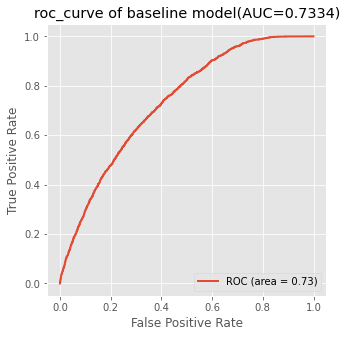

In [12]:
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test.iloc[:,1],test.iloc[:,2]) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
plt.savefig("baseline_roc.png")
roc_auc

In [13]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

df_importance_top20 = df_importance.sort_values(by="importance", ascending=False).iloc[0:20,:]
df_importance_top100 = df_importance.sort_values(by="importance", ascending=False).iloc[0:100,:]
# print(df_importance_top100.iloc[:,0].tolist())

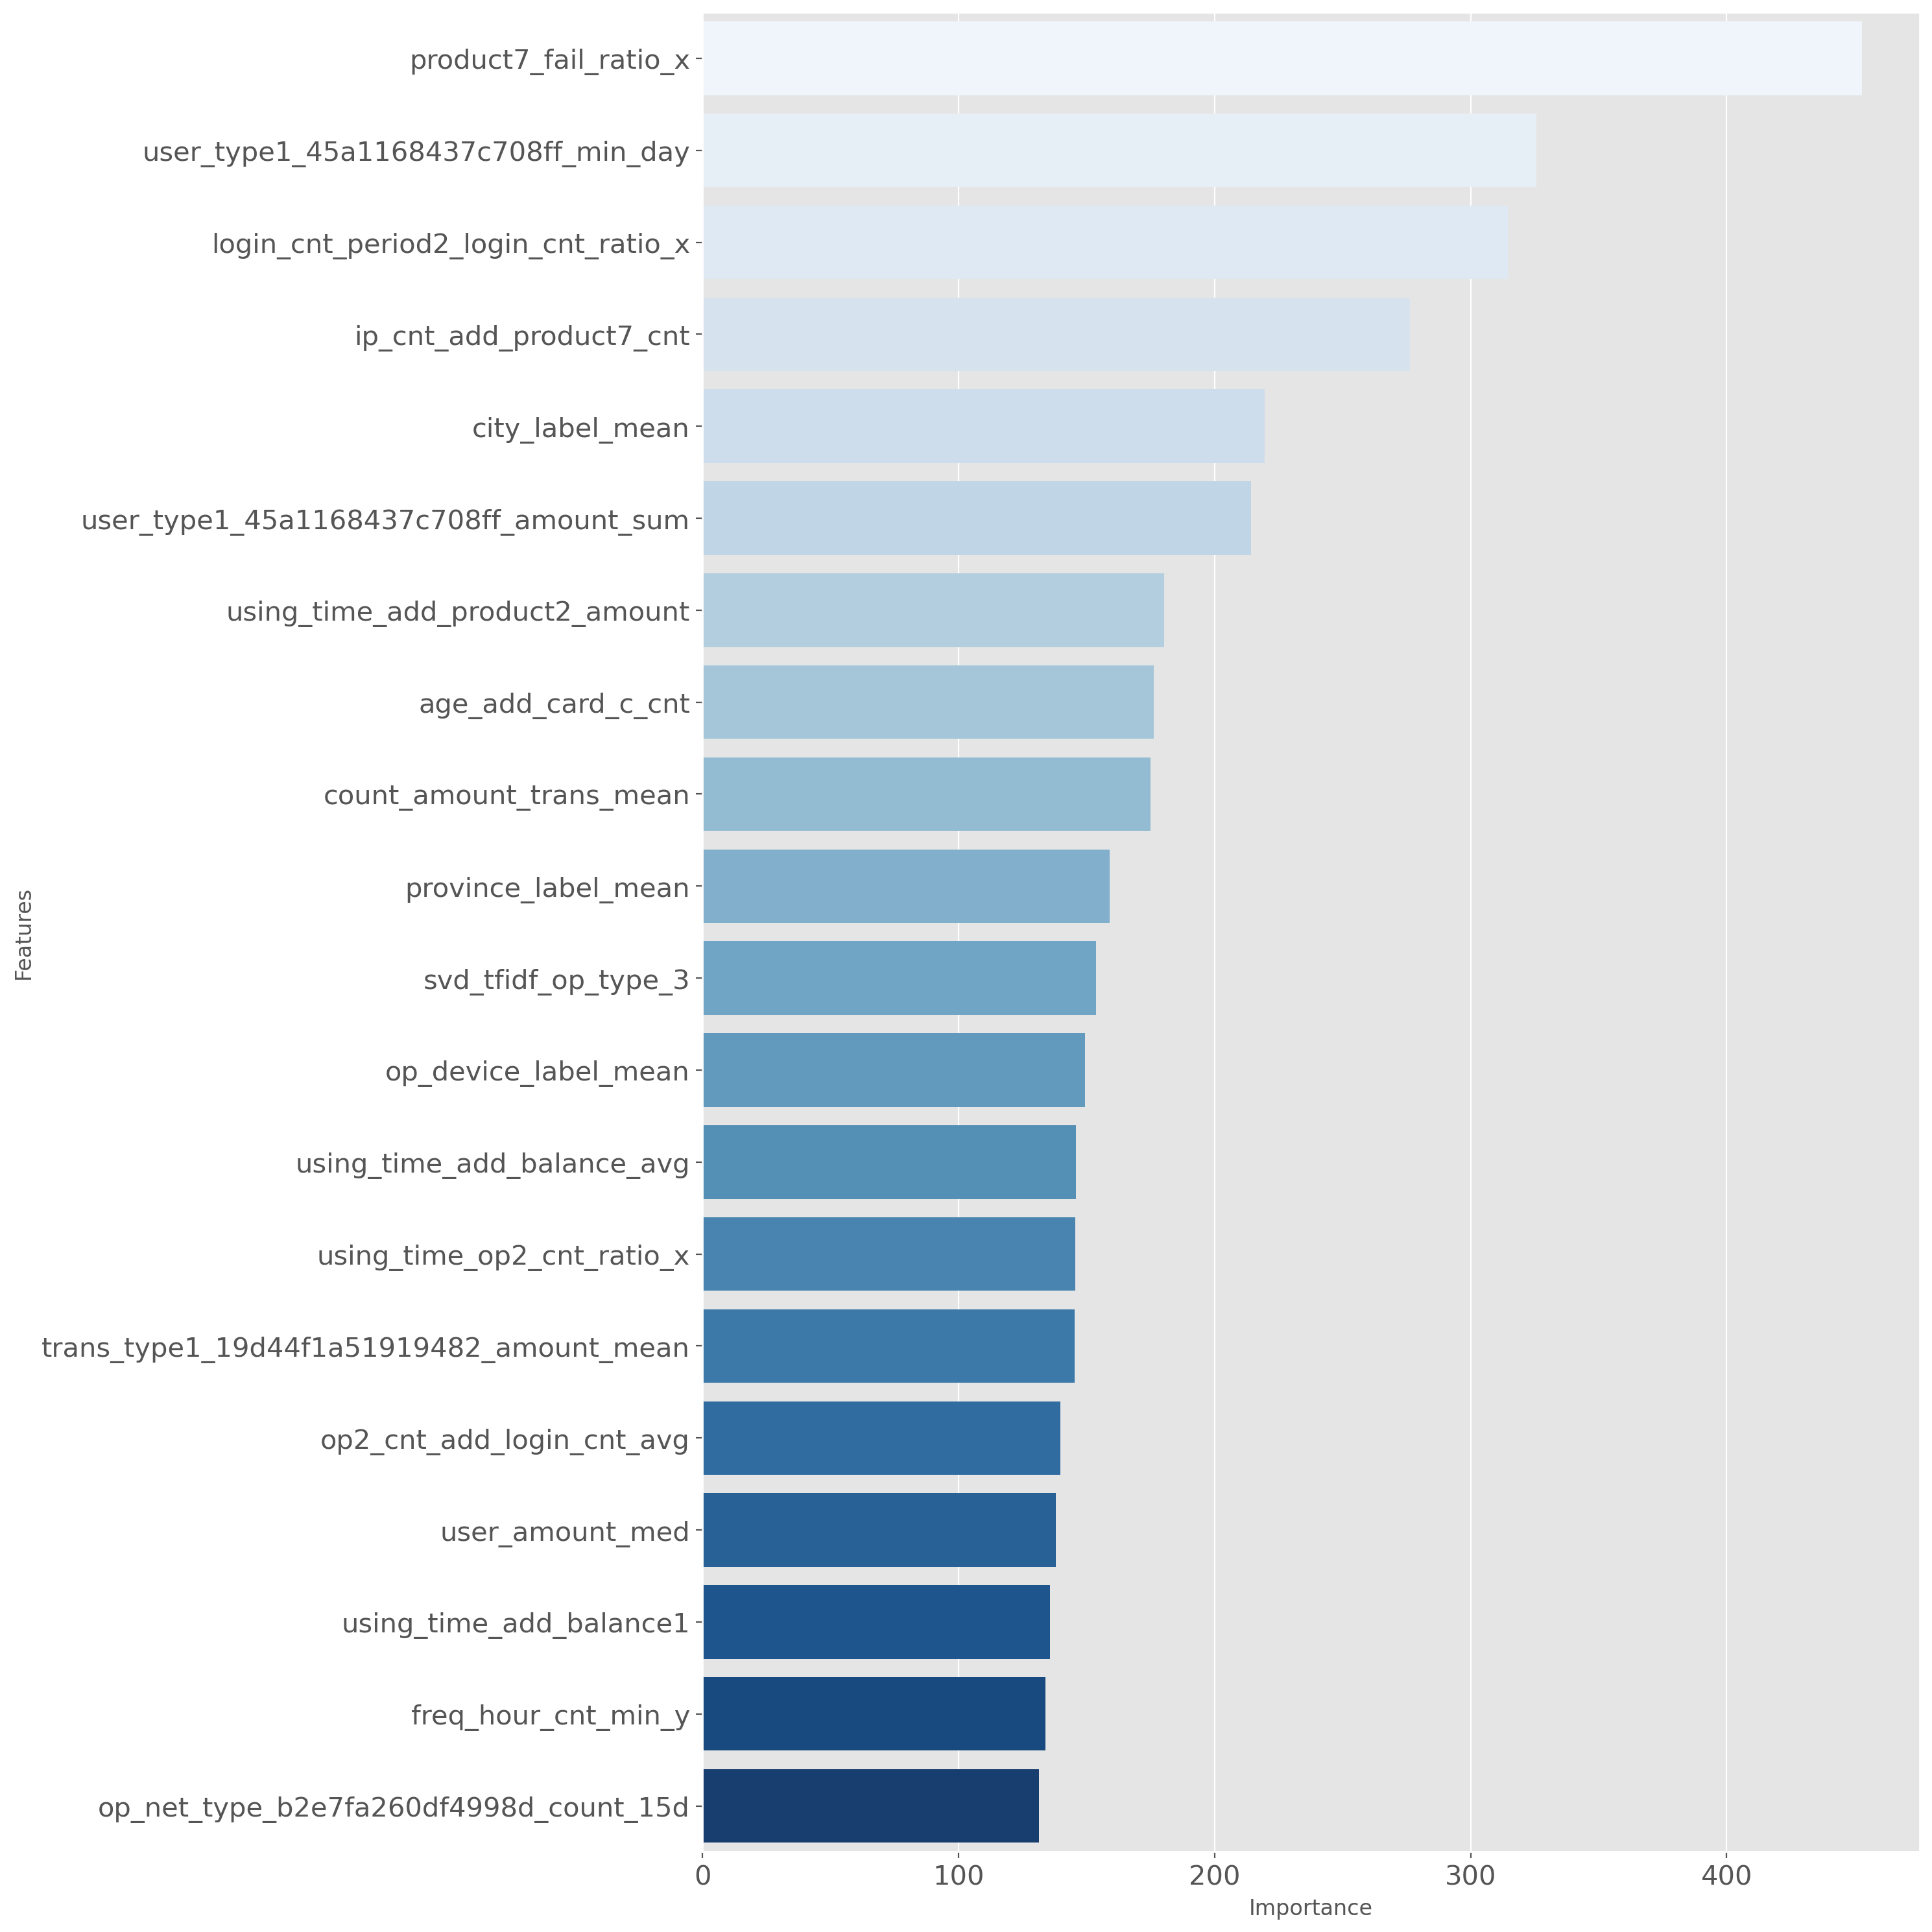

In [14]:
# feature importance visualization

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="importance", y="column", data=df_importance_top20, palette='Blues' ) 
# plt.title('LightGBM Features (avg over folds)')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Importance')
plt.ylabel('Features')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('lgbm_importances.png')

# XGBoost

In [15]:
%%time
ycol = 'label'
feature_names = list(
    filter(lambda x: x not in [ycol, 'user'], df_train.columns))

model = xgb.XGBClassifier( 
                           max_depth=6,
                           learning_rate=0.01,
                           n_estimators=10000,
                           subsample=0.8,
                           reg_alpha=10,
                           reg_lambda=12,
#                             tree_method='gpu_hist',
                           random_state=seed)

df_oof = df_train[['user', ycol]].copy()
df_oof['prob'] = 0
prediction = df_test[['user']]
prediction['prob'] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (trn_idx, val_idx) in enumerate(
        kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          eval_metric='auc', 
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val,)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val

    pred_test = lgb_model.predict_proba(df_test[feature_names])[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()

<timed exec>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_1 Training ================================

[0]	validation_0-auc:0.68462	validation_1-auc:0.66837
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[100]	validation_0-auc:0.76043	validation_1-auc:0.71734
[200]	validation_0-auc:0.78194	validation_1-auc:0.72535
[300]	validation_0-auc:0.79716	validation_1-auc:0.73036
[400]	validation_0-auc:0.81009	validation_1-auc:0.73406
[500]	validation_0-auc:0.82209	validation_1-auc:0.73665
[600]	validation_0-auc:0.83483	validation_1-auc:0.73802
[700]	validation_0-auc:0.84747	validation_1-auc:0.73942
[800]	validation_0-auc:0.85959	validation_1-auc:0.73997
[900]	validation_0-auc:0.87071	validation_1-auc:0.74056
Stopping. Best iteration:
[894]	validation_0-auc:0.87000	validation_1-auc:0.74062



<timed exec>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_2 Training ================================

[0]	validation_0-auc:0.68714	validation_1-auc:0.65709
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[100]	validation_0-auc:0.76261	validation_1-auc:0.71399
[200]	validation_0-auc:0.78387	validation_1-auc:0.72308
[300]	validation_0-auc:0.79882	validation_1-auc:0.72845
[400]	validation_0-auc:0.81162	validation_1-auc:0.73189
[500]	validation_0-auc:0.82386	validation_1-auc:0.73388
[600]	validation_0-auc:0.83589	validation_1-auc:0.73512
[700]	validation_0-auc:0.84766	validation_1-auc:0.73568
[800]	validation_0-auc:0.85902	validation_1-auc:0.73639
[900]	validation_0-auc:0.86943	validation_1-auc:0.73700
[1000]	validation_0-auc:0.87996	validation_1-auc:0.73764
[1100]	validation_0-auc:0.88946	validation_1-auc:0.73788
Stopping. Best iteration:
[1102]	validation_0-auc:0.88966	validation_1-auc:0.73791


Fold_3 Training ===================

In [25]:
pred_xgb = prediction

In [26]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby([
    'column'
])['importance'].agg('mean').sort_values(ascending=False).reset_index()
df_importance

,column,importance
0,user_amount_cnt,0.054871
1,agreement3_service3_x,0.033522
2,count_amount_trans_max,0.032645
3,agreement1_service3_x,0.019945
4,w2c_trans_type2_4_min,0.019757
...,...,...
740,sex_agreement3_y,0.000000
741,sex_agreement4_y,0.000000
742,sex_city_y,0.000000
743,sex_level_y,0.000000


In [27]:
auc = roc_auc_score(df_oof[ycol], df_oof['prob'])
print('auc:', auc)

auc: 0.7382839984113649


In [28]:
del auc

In [29]:
test_y = pd.read_csv('test_label_new.csv', index_col=0)
test = pd.merge(test_y,prediction, on='user')

In [30]:
test.head()

,user,label,prob
0,Train_00003,0,0.124882
1,Train_00004,0,0.315188
2,Train_00007,0,0.014052
3,Train_00015,1,0.315899
4,Train_00019,0,0.299570


0.7334836909084267

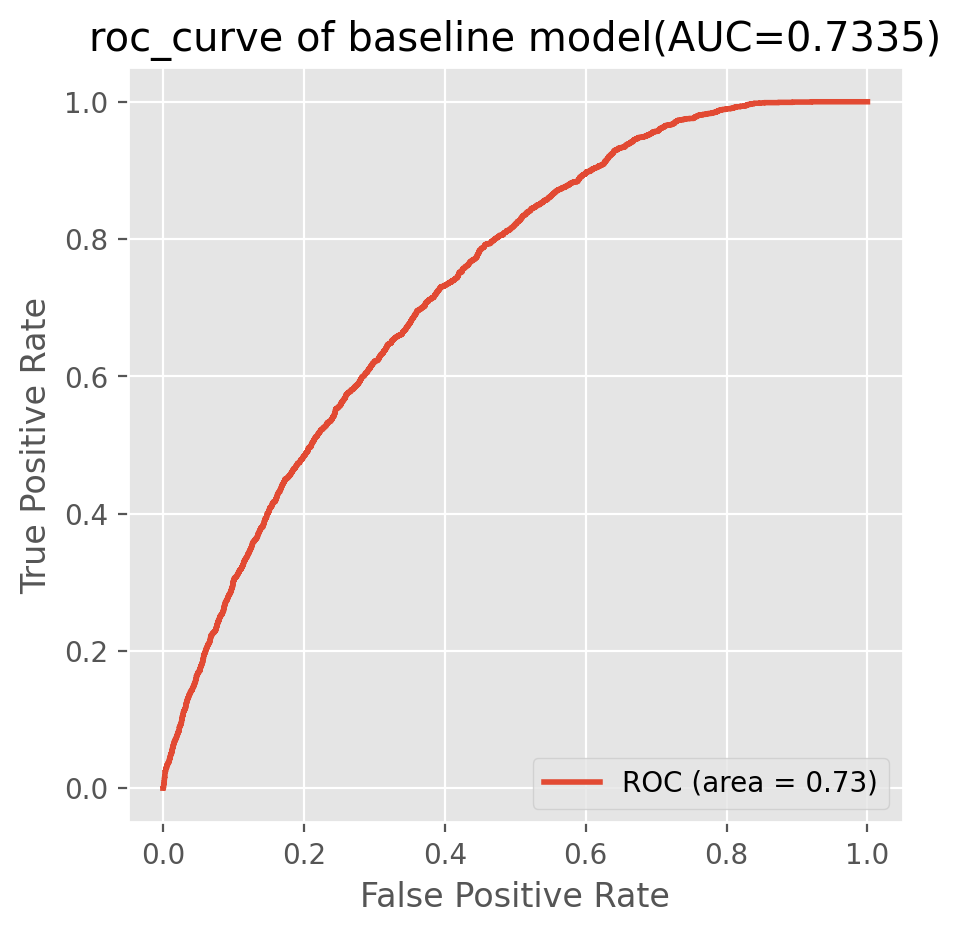

In [31]:
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score, roc_curve, auc
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test.iloc[:,1],test.iloc[:,2]) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
plt.savefig("baseline_roc.png")
roc_auc

In [32]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

df_importance_top20 = df_importance.sort_values(by="importance", ascending=False).iloc[0:20,:]
df_importance_top100 = df_importance.sort_values(by="importance", ascending=False).iloc[0:100,:]
# print(df_importance_top100.iloc[:,0].tolist())

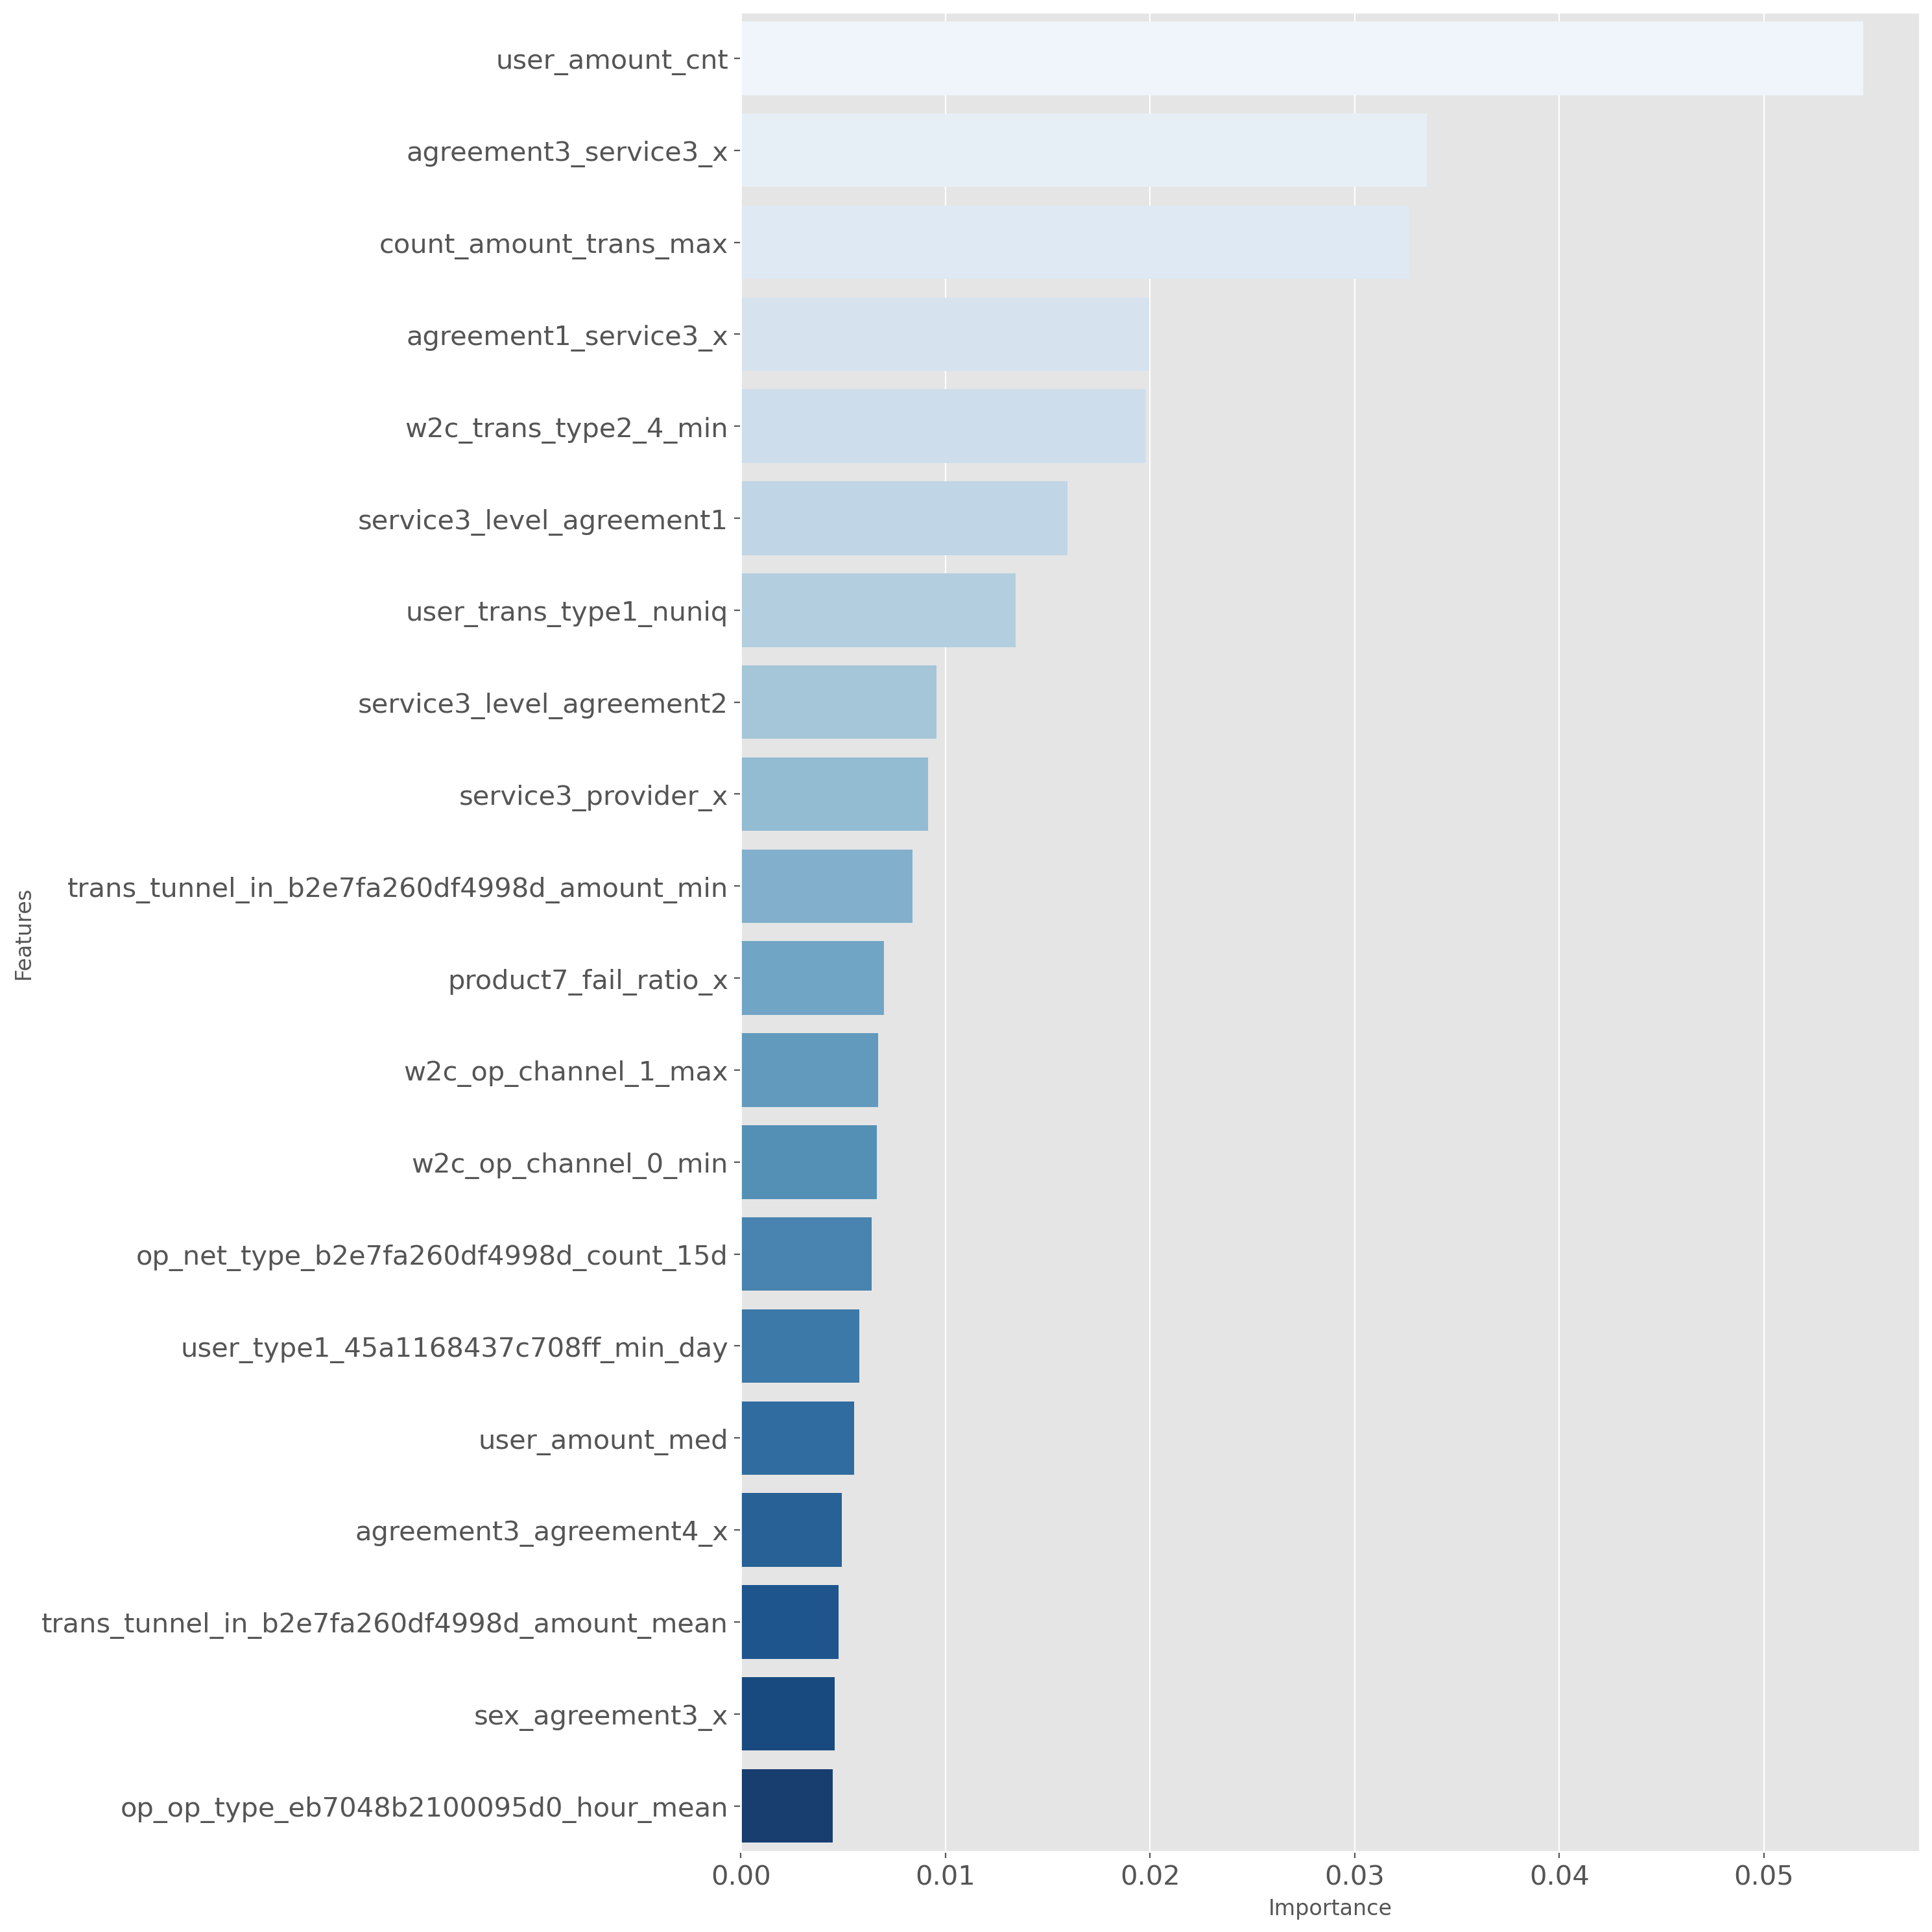

In [33]:
# feature importance visualization

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="importance", y="column", data=df_importance_top20, palette='Blues' ) 
# plt.title('LightGBM Features (avg over folds)')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Importance')
plt.ylabel('Features')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('xgb_importances.png')